<h2> Task 1 </h2>
A. Visualize the manipulator in the start state and target state. Comment on your thoughts  comparison the discretized orientation space from PS1 vs continuous orientation space in current problem set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class State:

    def __init__(self, angles: np.ndarray):
        """
        Represents the state of the 4-link manipulator.

        :param angles: 4 angles for each link of the manipulator in degrees. Shape: (4,).
        """
        assert angles.shape == (4,)
        assert (np.abs(angles) >= 0.0).all() and (np.abs(angles) <= 180.0).all()
        self._angles = angles.copy()
        self._joints = State._calculate_joint_positions(angles)

    @property
    def angles(self) -> np.ndarray:
        """
        :return: 4 angles for each link of the manipulator in degrees
        """
        return self._angles

    @property
    def joints(self) -> np.ndarray:
        """
        :return: Positions of the 5 joints of the manipulator. Shape: (5, 2).
        """
        return self._joints

    @staticmethod
    def _calculate_joint_positions(angles: np.ndarray) -> np.ndarray:
        seg = np.zeros((5, 2))
        a1, a2, a3, a4 = np.deg2rad(angles)
        T1 = State._se2(np.array([0, 0, a1]))  # this is the first joint, a simple rotation
        T2 = State._se2(
            np.array([1, 0, a2]))  # the second joint, it is a bar of d =1, plus a rotation for the second joint
        T3 = State._se2(np.array([1, 0, a3]))
        T4 = State._se2(np.array([1, 0, a4]))
        T5 = State._se2(
            np.array([1, 0, 0]))  # this is simply to express the lenght of the second bar, no rotation required
        p = T1 @ T2 @ np.array([0, 0, 1])
        seg[1, :] = p[:2]
        p = T1 @ T2 @ T3 @ np.array([0, 0, 1])
        seg[2, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ np.array([0, 0, 1])
        seg[3, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ T5 @ np.array([0, 0, 1])
        seg[4, :] = p[:2]
        return seg

    @staticmethod
    def _se2(q):
        x, y, t = q
        T = np.array([
            [np.cos(t), -np.sin(t), x],
            [np.sin(t), np.cos(t), y],
            [0, 0, 1]])
        return T

class ManipulatorEnv:

    OBSTACLES_DIM = 3  # x, y, radius (assume all obstacles are circles)
    N_LINKS = 4

    def __init__(self,
                 obstacles: np.ndarray,
                 initial_state: State,
                 collision_threshold: float = 0.1):
        assert len(obstacles.shape) == 2 and obstacles.shape[1] == ManipulatorEnv.OBSTACLES_DIM
        self._obstacles = obstacles.copy()
        self._state = initial_state
        self._collision_threshold = collision_threshold

    @property
    def state(self) -> State:
        return self._state

    @state.setter
    def state(self, new_state: State) -> None:
        self._state = new_state

    def check_collision(self, state_to_check: State) -> bool:
        """
        Checks state (configuration) for the collisions.
        :return True if collision, False if no collisions
        """
        for obs in self._obstacles:
            for i in range(ManipulatorEnv.N_LINKS):
                segment = state_to_check.joints[[i, i+1], :]
                r = obs[2] + self._collision_threshold
                p0 = obs[:2]
                p1 = segment[0]
                p2 = segment[1]

                # Check if p1 or p2 in circle
                if np.linalg.norm(p0 - p1) <= r or np.linalg.norm(p0 - p2) <= r:
                    return True

                # Find projection
                t = np.sum((p0 - p1) * (p2 - p1)) / (np.linalg.norm(p2 - p1) ** 2)
                # Check if the projection is on the line
                # (in other words, if line is fully in the circle)
                if t < 0.0 or t > 1.0:
                    continue
                p4 = p1 + t * (p2 - p1)

                if np.linalg.norm(p0 - p4) <= r:
                    return True

                # distance = np.linalg.norm(np.cross(p2-p1, p1-p0)) / np.linalg.norm(p2-p1)
                # pro
                # distance = distance - r
                # if distance <= r:
                #     return False
        return False

    def render(self, plt_show=True) -> None:
        """
        Displays current configuration.
        :param plt_show: whether to call plt.show() or not
        """
        self._plot_segment(self._state.joints[[0, 1], :], np.array([1, 0, 0]),
                           is_start_link=True)
        self._plot_segment(self._state.joints[[1, 2], :], np.array([0, 1, 0]))
        self._plot_segment(self._state.joints[[2, 3], :], np.array([0, 0, 1]))
        self._plot_segment(self._state.joints[[3, 4], :], np.array([1, 0, 1]),
                           is_end_link=True)
        for obs in self._obstacles:
            plt.gca().add_patch(
                plt.Circle((obs[0], obs[1]), obs[2], fill=True))
        plt.axis('equal')
        if plt_show:
            plt.show()

    @staticmethod
    def _plot_segment(s, color_, is_start_link=False, is_end_link=False):
        plt.plot(s[:, 0], s[:, 1], linewidth=2, color=color_)
        if is_end_link:
            plt.plot(s[1, 0], s[1, 1], marker='>', color=color_)
        else:
            plt.plot(s[1, 0], s[1, 1], marker='o', color=color_)
        if is_start_link:
            plt.plot(s[0, 0], s[0, 1], marker='X', color=color_)
        else:
            plt.plot(s[0, 0], s[0, 1], marker='o', color=color_)

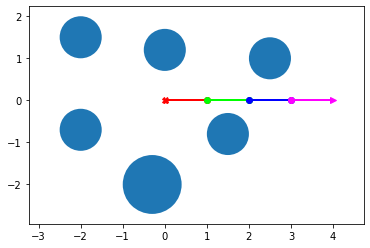

In [3]:
import pickle
#START STATE
with open("/content/drive/MyDrive/PS2/data.pickle", "rb") as handle:
  data = pickle.load(handle)
  start_state = State(np.array(data["start_state"]))
  goal_state = State(np.array(data["goal_state"]))
  env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
  env.state = start_state
  env.render()

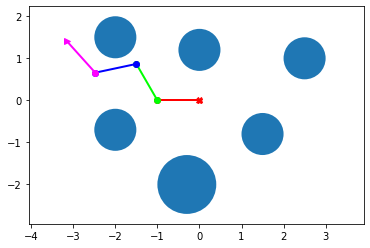

In [4]:
#TARGET STATE
env.state = goal_state
env.render()

Comment on your thoughts comparison the discretized orientation space from PS1 vs continuous orientation space in current problem set.<br>

The discretized orientation space from PS1 is too small, so it leads to visiting an unnecessary number of states and takes a larger memory than the continuous orientation space in current problem set. <br>

B. Visualize the manipulator in 4 random orientations that include both colliding and non-colliding configurations. Check what does the ManipulatorEnv.check_collision function returns for those configurations. Comment on your observations.

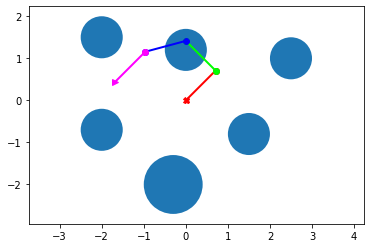

True

In [5]:
q1 = State(np.array([45,90,60,30]))
env.state = q1
env.render()
env.check_collision(q1)

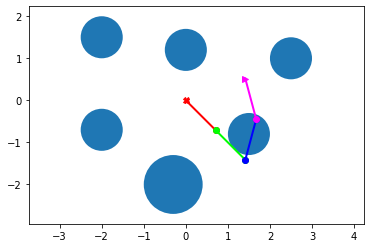

True

In [6]:
q2 = State(np.array([-45,0,120,30]))
env.state = q2
env.render()
env.check_collision(q2)

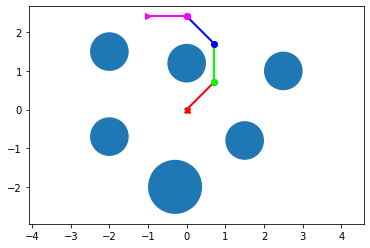

False

In [7]:
q3 = State(np.array([45,45,45,45]))
env.state = q3
env.render()
env.check_collision(q3)

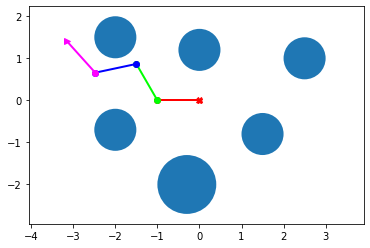

False

In [8]:
q4 = State(np.array([-180,-60,72,-60]))
env.state = q4
env.render()
env.check_collision(q4)

Comment on your observations <br>
The manipulator is fixed in (0,0) because in 4 random orientations that include both colliding and non-colliding configurations still have the same coordinate of root (0,0), while 3 links are in different coordinate.

<h2> Task 2 </h2>
A. You need to implement the RRT algorithm for agent in continuous domain. The starting configuration of the agent is (0, 0, 0, 0) and the goal configuration is (-180.0, -60.0, 72.0, -60.0). For searching nearest pose use L1 distance between two configuration vectors.

In [26]:
from matplotlib.cbook import delete_masked_points
from typing import List, Callable
from typing import Union
import matplotlib.animation as animation

def angle_difference(angle1: Union[float, np.ndarray], 
                         angle2: Union[float, np.ndarray],
                     directional=False) -> Union[float, np.ndarray]:
        """
        :param angle1: first angle in degrees
        :param angle2: second angle in degrees
        :param return: signed diff between angles (from 0 to 180)
        """
        if type(angle1) is np.ndarray:
          assert type(angle1) == type(angle2)
          assert angle1.shape == angle2.shape
          return np.array([angle_difference(a1, a2) for (a1, a2) in zip(angle1, angle2)])
        delta_angle = angle1 - angle2
        delta_angle = (delta_angle + 180) % 360 - 180
        return delta_angle

def angle_linspace(start_angle: Union[float, np.ndarray],
                       end_angle: Union[float, np.ndarray],
                       n: int):
      """
      :param start_angle: start angle (or whole configuration) in degrees
      :param end_angle: end angle (or whole configuration) in degrees
      :param n: number of steps
      """
      if type(start_angle) is np.ndarray:
        assert type(start_angle) == type(end_angle)
        assert start_angle.shape == end_angle.shape
        return np.array([angle_linspace(a1, a2, n) for (a1, a2) in zip(start_angle, end_angle)]).T

      step = angle_difference(end_angle, start_angle) / n
      result = [start_angle]
      for _ in range(n):
        new_item = result[-1] + step
        if np.abs(new_item) > 180.0:
            if new_item > 0.0:
                new_item = new_item - 360.0
            else:
                new_item = new_item + 360.0
        result.append(new_item)
      return np.array(result)

class Tree():
    def __init__(self, angles, parent):
        self.angles = angles
        self.parent = parent
        self.joints = Tree._calculate_joint_positions(angles)

    def _calculate_joint_positions(angles: np.ndarray) -> np.ndarray:
        seg = np.zeros((5, 2))
        a1, a2, a3, a4 = np.deg2rad(angles)
        T1 = State._se2(np.array([0, 0, a1]))  # this is the first joint, a simple rotation
        T2 = State._se2(
            np.array([1, 0, a2]))  # the second joint, it is a bar of d =1, plus a rotation for the second joint
        T3 = State._se2(np.array([1, 0, a3]))
        T4 = State._se2(np.array([1, 0, a4]))
        T5 = State._se2(
            np.array([1, 0, 0]))  # this is simply to express the lenght of the second bar, no rotation required
        p = T1 @ T2 @ np.array([0, 0, 1])
        seg[1, :] = p[:2]
        p = T1 @ T2 @ T3 @ np.array([0, 0, 1])
        seg[2, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ np.array([0, 0, 1])
        seg[3, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ T5 @ np.array([0, 0, 1])
        seg[4, :] = p[:2]
        return seg

    @staticmethod
    def _se2(q):
        x, y, t = q
        T = np.array([
            [np.cos(t), -np.sin(t), x],
            [np.sin(t), np.cos(t), y],
            [0, 0, 1]])
        return T

def convert_angle(angle):
    for i in range (len(angle)):
        if np.abs(angle[i]) > 180.0:
          if angle[i] > 0.0:
            angle[i] = angle[i] - 360.0
          else:
            angle[i] = angle[i] + 360.0
    return angle

def generate_random_state(state, goal_state, env):
    delta = 40
    count = 0
    if np.random.random() > 0.01:
        random_state = np.array([(s + np.random.randint(-delta,delta)) for s in state]) 
        random_state = convert_angle(random_state)        
        while env.check_collision(State(random_state)) == True:
          count += 1
          random_state = np.array([(s + np.random.randint(-delta,delta)) for s in state])
          random_state = convert_angle(random_state)    
          if count >= 3000:
            delta -= 10
          if count >= 4000:
            break 
    else:
         random_state = goal_state
    return random_state, count

def L1_norm(state):
    return np.linalg.norm(state, ord=1)

def nearest_pose(list_state, randpose):
    l = [L1_norm(angle_difference(s, randpose.angles)) for s in list_state]
    return list_state[l.index(min(l))]

def steer(node_start, node_end):
    dist = angle_difference(node_start.angles, node_end.angles)
    ndist = [min(10,d) for d in dist]
    new_state = convert_angle(node_start.angles + ndist) 
    return new_state

def RRTPlanner(env, start_state, goal_state, step_size = 10.0):
    start_tree = Tree(start_state, None)
    goal_tree = Tree(goal_state, None)
    list_state = angle_linspace(start_state, goal_state, 100)
    list_tree = [start_tree]
    state_now = start_state
    itermax = 1000
    path = [start_tree.angles]
    for i in range(itermax):
        rand_state1, count = generate_random_state(state_now, goal_state, env)
        if count > 1000:
          itermax += 100 
        rand_tree = Tree(rand_state1, None)
        near_state = nearest_pose(list_state, rand_tree)
        near_tree = Tree(near_state, None)
        new_state = steer(near_tree, rand_tree)
        env.state = State(start_state)
        env.render(plt_show=False)
        if env.check_collision(State(new_state)) == False: 
            new_tree = Tree(new_state, near_tree)
            state_now = new_tree.angles
            list_tree.append(new_tree)
            env.state = State(new_state)
            env.render(plt_show=False)
            path.append(new_state)
            if L1_norm(angle_difference(new_tree.angles, goal_tree.angles)) < step_size:
                print("The number of states:", i)
                final_state = steer(new_tree, goal_tree)
                final_tree = Tree(final_state, new_tree)
                path.append(final_tree.angles)
                print("The final state:", final_tree.angles)
                return path 

    return None

The number of states: 374
The final state: [180. -60.  72. -60.]
RRT planner has finished successfully


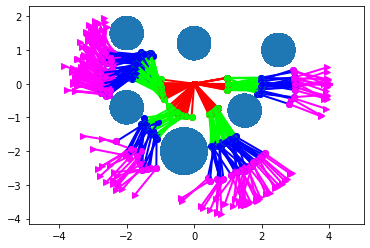

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import imageio

# You are free to change any interfaces for your needs.

def plotting_results(env, plan, save_path: str = 'solve_4R.gif',image_path='image/'):
    fig, ax = plt.subplots()
    ax.set_xlim([-4, 4])
    ax.set_ylim([-2.5, 2.5])
    path = []
    for i, state in enumerate(plan):
        env.state = State(state)
        env.render(plt_show=False)
        path.append(image_path + str(i) + '.png')
        plt.savefig(path[-1])
        plt.clf()
    with imageio.get_writer(save_path, mode='I') as writer:
      for filename in path:
        image = imageio.imread(filename)
        writer.append_data(image)

def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])

    plan = RRTPlanner(env,start_state.angles, goal_state.angles)
    plotting_results(env,plan)

    print("RRT planner has finished successfully")
if __name__ == '__main__':
    main()

The number of states: 210
The final state: [180. -60.  72. -60.]
RRT planner has finished successfully


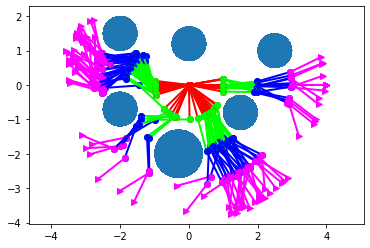

<Figure size 432x288 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import imageio

# You are free to change any interfaces for your needs.

def plotting_results(env, plan, save_path: str = 'solve_4R.gif',image_path='image/'):
    fig, ax = plt.subplots()
    ax.set_xlim([-4, 4])
    ax.set_ylim([-2.5, 2.5])
    path = []
    for i, state in enumerate(plan):
        env.state = State(state)
        env.render(plt_show=False)
        path.append(image_path + str(i) + '.png')
        plt.savefig(path[-1])
        plt.clf()
    with imageio.get_writer(save_path, mode='I') as writer:
      for filename in path:
        image = imageio.imread(filename)
        writer.append_data(image)

def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])

    plan = RRTPlanner(env,start_state.angles, goal_state.angles)
    plotting_results(env,plan)

    print("RRT planner has finished successfully")
if __name__ == '__main__':
    main()

B. Comment on how many states have been visited? What is the final trajectory size? Can you comment on the optimality of the plan? You can also collect some observations and statistics across multiple
runs. <br>
210 states have been visited. The final trajectory size is $210 × 4$. <br> 
I optimize by using goal bias sampling method. It adds a higher probability for goal configuration point on top of the uniform sampling.

C. Try to change weight of rotation in calculation of distance between two agent positions. We suggest you to build a distance function based on weighted sum of the angle distances. Comment on the results. 

In [ ]:
def L1_norm(state):
    return np.linalg.norm(state, ord=1)

def steer1(node_start, node_end):
    dist = angle_difference(node_start.angles, node_end.angles)
    new_state = convert_angle(node_start.angles + dist * 10 / L1_norm(dist))
    return new_state

def RRTPlanner(env, start_state, goal_state, step_size = 10.0):
    start_tree = Tree(start_state, None)
    goal_tree = Tree(goal_state, None)
    list_state = angle_linspace(start_state, goal_state, 100)
    list_tree = [start_tree]
    state_now = start_state
    
    itermax = 1000
    for i in range(itermax):
        rand_state, count = generate_random_state(state_now, goal_state, env)
        if count > 1000:
          itermax += 100 
        rand_tree = Tree(rand_state, None)
        near_state = nearest_pose(list_state, rand_tree)
        near_tree = Tree(near_state, None)
        new_state = steer1(near_tree, rand_tree)
        env.state = State(start_state)
        env.render(plt_show=False)
        if env.check_collision(State(new_state)) == False: 
            new_tree = Tree(new_state, near_tree)
            state_now = new_tree.angles
            list_tree.append(new_tree)
            env.state = State(new_state)
            env.render(plt_show=False)
            if L1_norm(angle_difference(new_tree.angles, goal_tree.angles)) < step_size:
                print("The number of states:", i)
                final_state = steer(new_tree, goal_tree)
                final_tree = Tree(final_state, new_tree)
                print("The final state:", final_tree.angles)
                return extract_path(final_tree, goal_state)

    return None

The number of states: 555
The final state: [-179.95143869  -67.33375515   80.68644136  -56.06875782]


[array([-180.,  -60.,   72.,  -60.]),

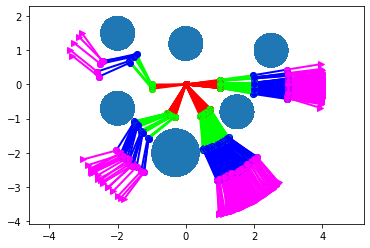

In [ ]:
RRTPlanner(env,start_state.angles, goal_state.angles)

My first distance function compares angles of near_tree with 10 degrees and chooses the smaller to become new_state. <br> 
My second distance function creates new_state by adding $10\times \frac{dist}{\|dist\|_1} \leq 10$ (where $dist$ - angle different between near_tree and random_tree) to angles of near_tree. <br>
The first method returns the correct value of final state [-180.0, -60.0, 72.0, -60.0], while the second's final state is an approximation of [-179.95143869,  -67.33375515,   80.68644136  -56.06875782]

D. Try to change step size used for RRT branches. Comment on the results.

In [ ]:
def RRTPlanner(env, start_state, goal_state, step_size):  
    start_tree = Tree(start_state, None)
    goal_tree = Tree(goal_state, None)
    list_state = angle_linspace(start_state, goal_state, 100)
    list_tree = [start_tree]
    state_now = start_state
    
    itermax = 1000
    for i in range(itermax):
        rand_state, count = generate_random_state(state_now, goal_state, env)
        if count > 1000:
          itermax += 100 
        rand_tree = Tree(rand_state, None)
        near_state = nearest_pose(list_state, rand_tree)
        near_tree = Tree(near_state, None)
        new_state = steer1(near_tree, rand_tree)
        env.state = State(start_state)
        env.render(plt_show=False)
        if env.check_collision(State(new_state)) == False: 
            new_tree = Tree(new_state, near_tree)
            state_now = new_tree.angles
            list_tree.append(new_tree)
            env.state = State(new_state)
            env.render(plt_show=False)
            if L1_norm(angle_difference(new_tree.angles, goal_tree.angles)) < step_size:
                print("The number of states:", i)
                final_state = steer(new_tree, goal_tree)
                final_tree = Tree(final_state, new_tree)
                print("The final state:", final_tree.angles)
                return extract_path(final_tree, goal_state)

    return None

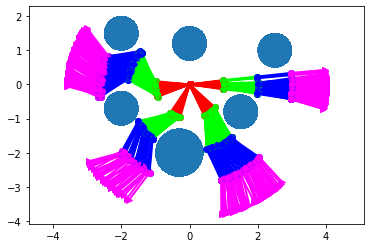

In [ ]:
RRTPlanner(env,start_state.angles, goal_state.angles, 5.0) #Change step size

The number of states: 318
The final state: [-176.16883567  -49.99176349   62.00223474  -61.2028339 ]


[array([-180.,  -60.,   72.,  -60.]),

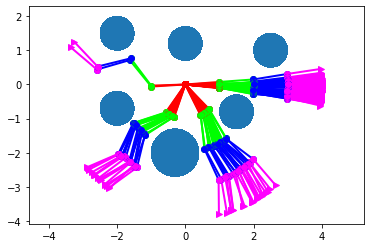

In [ ]:
RRTPlanner(env,start_state.angles, goal_state.angles, 15.0) #Change step size

When step size is decreased from 10 to 5, the final trajectory size is bigger. Besides that, the program runs slower and does not reach to the goal state. <br>
When step size is increased from 10 to 15, the final trajectory size is smaller. Program run faster but the distances between angles are bigger. 